In [1]:
import numpy as np
from copy import deepcopy
from math import sqrt, ceil
from operator import itemgetter
from scipy.stats import rankdata
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import auc, roc_curve, silhouette_score, accuracy_score
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

## Preprocessing

#### load gene expression data

In [2]:
def load_data(dataFile):
	'''
	PATIENT   TCGA-AR-A24H  TCGA-AR-A24L  TCGA-AR-A24M  TCGA-AR-A24N
	A1CF      -0.436158     -0.276784     -0.309453     -0.305223
	A2M       1.90128       2.72735       4.03939       1.33212
	A4GALT    -0.408337     -0.247608     -0.260444     -0.234695
	'''
	with open(dataFile) as fin:
		lines = fin.readlines()
	## preprocessing
	lines = list(map(lambda line:line.rstrip().split('\t'), lines))
	## header
	sample = np.array(lines[0][1:])
	## body
	gene = list()
	expr = list()
	for line in lines[1:]:
		gene.append(line[0])
		expr.append(line[1:])
	gene = np.array(gene)
	expr = np.array(expr, dtype=np.float32).T  # genewise-->samplewise
	## maek result
	result = {'sample':sample,   #sample=array([TCGA-AR-A24H, ...])
	          'expr':expr,       #expr=array([[-0.436158, 1.9, ...],[],...])
	          'gene':gene}       #gene=array([A1CF, ...])
	return result

In [3]:
expression_data = load_data('ex_EXPRESSION.txt')

In [4]:
expression_data['sample']

array(['TCGA-AR-A24H', 'TCGA-AR-A24L', 'TCGA-AR-A24M', 'TCGA-AR-A24N',
       'TCGA-AR-A24O', 'TCGA-AR-A24Q', 'TCGA-AR-A24S', 'TCGA-AR-A2LE',
       'TCGA-AR-A2LH', 'TCGA-AR-A5QQ', 'TCGA-B6-A0I2', 'TCGA-B6-A0I5',
       'TCGA-B6-A0I6', 'TCGA-B6-A0I8', 'TCGA-B6-A0I9', 'TCGA-B6-A0IA',
       'TCGA-B6-A0IC', 'TCGA-B6-A0IJ', 'TCGA-B6-A0IK', 'TCGA-B6-A0IM',
       'TCGA-B6-A0IO', 'TCGA-B6-A0IP', 'TCGA-B6-A0IQ', 'TCGA-B6-A0RE',
       'TCGA-B6-A0RG', 'TCGA-B6-A0RH', 'TCGA-B6-A0RI', 'TCGA-B6-A0RN',
       'TCGA-B6-A0RO', 'TCGA-B6-A0RT', 'TCGA-B6-A0RU', 'TCGA-B6-A0RV',
       'TCGA-B6-A0WT', 'TCGA-B6-A0WW', 'TCGA-B6-A0WX', 'TCGA-B6-A0WZ',
       'TCGA-B6-A0X1', 'TCGA-B6-A0X4', 'TCGA-B6-A0X7', 'TCGA-B6-A1KF',
       'TCGA-B6-A1KN', 'TCGA-B6-A2IU', 'TCGA-B6-A401', 'TCGA-B6-A409',
       'TCGA-B6-A40B', 'TCGA-BH-A0EA', 'TCGA-BH-A18J', 'TCGA-BH-A18J',
       'TCGA-BH-A18L', 'TCGA-BH-A18L', 'TCGA-BH-A18N', 'TCGA-BH-A18N',
       'TCGA-BH-A18P', 'TCGA-BH-A18P', 'TCGA-BH-A18Q', 'TCGA-BH-A18Q',
      

In [5]:
expression_data['sample'].shape

(189,)

In [6]:
np.unique(expression_data['sample']).shape

(165,)

In [7]:
expression_data['expr']

array([[-0.436158 ,  1.90128  , -0.408337 , ..., -0.0931192, -0.0339892,
         0.242093 ],
       [-0.276784 ,  2.72735  , -0.247608 , ...,  0.220333 , -0.0403549,
        -0.0112335],
       [-0.309453 ,  4.03939  , -0.260444 , ...,  0.22053  ,  0.0239129,
         0.0104413],
       ...,
       [-0.235595 ,  0.350077 , -0.225151 , ...,  0.692433 , -0.146285 ,
        -0.171493 ],
       [-0.269673 ,  6.46811  , -0.186206 , ...,  0.951302 , -0.131691 ,
        -0.132346 ],
       [-0.362266 ,  1.70122  , -0.146143 , ...,  0.594392 , -0.203573 ,
        -0.232338 ]], dtype=float32)

In [8]:
expression_data['expr'].shape

(189, 12027)

In [9]:
expression_data['gene']

array(['A1CF', 'A2M', 'A4GALT', ..., 'ZYX', 'ZZEF1', 'ZZZ3'], dtype='<U13')

In [10]:
expression_data['gene'].shape

(12027,)

#### load network data

In [11]:
def load_network(dataFile):
	'''
	GENE1   GENE2
	RPL37A  RPS27A
	MRPL1   MRPS36
	RFC3    SPRTN
	'''
	with open(dataFile) as fin:
		lines = fin.readlines()
	## preprocessing
	lines = list(map(lambda line:line.rstrip().split('\t'), lines))
	## list of edges
	edgeList = lines[1:]
	## gene set
	geneSet=set()
	for edge in edgeList:
		geneSet.add(edge[0])
		geneSet.add(edge[1])
	## make result
	result = {'edge':edgeList,   #edge=[[RPL37A, RPS27A], [], ...]
	          'gene':geneSet}    #gene={RPL37A, RPS27A, MRPL1, ...}
	return result

In [12]:
network_data = load_network('ex_NETWORK.txt')

In [13]:
np.array(network_data['edge']).shape  #nested list

(229285, 2)

In [14]:
len(network_data['gene'])

12175

#### load clinical data

In [15]:
def load_clinical(dataFile):
	'''
	PATIENT         LABEL
	TCGA-AR-A24H    0
	TCGA-AR-A24L    0
	TCGA-AR-A24M    0
	'''
	with open(dataFile) as fin:
		lines = fin.readlines()
	## preprocessing
	lines = list(map(lambda line:line.rstrip().split('\t'), lines))
	## make result
	result = dict()
	for line in lines[1:]:
		sample = line[0]
		label = int(line[1])
		result[sample]=label   #result={TCGA-AR-A24H: 0, ...}
	return result

In [16]:
clinical_data = load_clinical('ex_CLINICAL.txt')

In [17]:
clinical_data

{'TCGA-AR-A24H': 0,
 'TCGA-AR-A24L': 0,
 'TCGA-AR-A24M': 0,
 'TCGA-AR-A24N': 0,
 'TCGA-AR-A24O': 0,
 'TCGA-AR-A24Q': 0,
 'TCGA-AR-A24S': 0,
 'TCGA-AR-A2LE': 0,
 'TCGA-AR-A2LH': 1,
 'TCGA-AR-A5QQ': 1,
 'TCGA-B6-A0I2': 0,
 'TCGA-B6-A0I5': 0,
 'TCGA-B6-A0I6': 1,
 'TCGA-B6-A0I8': 1,
 'TCGA-B6-A0I9': 1,
 'TCGA-B6-A0IA': 0,
 'TCGA-B6-A0IC': 1,
 'TCGA-B6-A0IJ': 0,
 'TCGA-B6-A0IK': 1,
 'TCGA-B6-A0IM': 0,
 'TCGA-B6-A0IO': 0,
 'TCGA-B6-A0IP': 0,
 'TCGA-B6-A0IQ': 0,
 'TCGA-B6-A0RE': 0,
 'TCGA-B6-A0RG': 0,
 'TCGA-B6-A0RH': 0,
 'TCGA-B6-A0RI': 0,
 'TCGA-B6-A0RN': 0,
 'TCGA-B6-A0RO': 0,
 'TCGA-B6-A0RT': 0,
 'TCGA-B6-A0RU': 0,
 'TCGA-B6-A0RV': 0,
 'TCGA-B6-A0WT': 0,
 'TCGA-B6-A0WW': 1,
 'TCGA-B6-A0WX': 1,
 'TCGA-B6-A0WZ': 0,
 'TCGA-B6-A0X1': 0,
 'TCGA-B6-A0X4': 1,
 'TCGA-B6-A0X7': 1,
 'TCGA-B6-A1KF': 0,
 'TCGA-B6-A1KN': 0,
 'TCGA-B6-A2IU': 0,
 'TCGA-B6-A401': 0,
 'TCGA-B6-A409': 1,
 'TCGA-B6-A40B': 0,
 'TCGA-BH-A0EA': 1,
 'TCGA-BH-A18J': 1,
 'TCGA-BH-A18L': 1,
 'TCGA-BH-A18N': 1,
 'TCGA-BH-A18P': 1,


In [18]:
len(clinical_data.keys())

165

#### map labels

In [19]:
def map_labels(clinical,sampleList):
	try:
		result = list(map(lambda sample:clinical[sample], sampleList))
	except:
		print('ERROR: There is a mismatched sample between expression data and clinical data. Please check sample names')
		exit(1)
	return np.array(result)

In [20]:
labels = map_labels(clinical_data, expression_data['sample'])

In [21]:
labels.shape

(189,)

#### find common genes

In [22]:
def find_commonGeneList(X,Y):
	X=set(X)
	Y=set(Y)
	result = X.intersection(Y)
	result = list(result)
	result = sorted(result)  # sorted by gene symbol A->Z
	return result

In [23]:
commonGeneList = find_commonGeneList(network_data['gene'], expression_data['gene'])   #sorted list

#### restrict network

In [24]:
def restrict_network(network,commonGeneList):
	## find edges with target genes
	edgeList = list()
	commonGeneSet = set(commonGeneList)
	for edge in network['edge']:
		if edge[0] in commonGeneSet and edge[1] in commonGeneSet:
			edgeList.append(edge)
	## make result
	result = {'edge':edgeList,
	          'gene':commonGeneSet}
	return result

In [25]:
network_restricted = restrict_network(network_data,commonGeneList)    #delete redundant edges

In [26]:
np.array(network_restricted['edge']).shape

(150168, 2)

In [27]:
len(network_restricted['gene'])

8819

#### restrict expression data

In [28]:
def make_gene2idx(geneList):
	result=dict()
	for i, gene in enumerate(geneList):
		result[gene]=i
	return result

def restrict_data(data,commonGeneList):
	## find indices corresponding to common genes
	geneToIdx = make_gene2idx(data['gene'])   #geneToIdx={'A1CF':0,'A2M':1, ...}
	idx = list(map(lambda gene:geneToIdx[gene], commonGeneList))
	## make result
	result = {'sample':deepcopy(data['sample']),
	          'expr':data['expr'][:,idx],
	          'gene':np.array(commonGeneList)}
	return result

In [29]:
expression_restricted = restrict_data(expression_data, commonGeneList)

In [30]:
expression_restricted['sample'].shape

(189,)

In [31]:
expression_restricted['expr'].shape

(189, 8819)

In [32]:
expression_restricted['gene'].shape

(8819,)

#### data information

In [33]:
n_samples, n_genes = expression_restricted['expr'].shape
n_edges            = len(network_restricted['edge'])
print('    n_samples: %d' % n_samples)
print('    n_genes  : %d\t(common genes in both EXPRESSION and NETWORK)' % n_genes)
print('    n_edges  : %d\t(edges with the common genes)' % n_edges)

    n_samples: 189
    n_genes  : 8819	(common genes in both EXPRESSION and NETWORK)
    n_edges  : 150168	(edges with the common genes)


In [34]:
sum(labels==0)

99

## CPR

In [35]:
class CPR:
	def __init__(self,
		         dampingFactor=0.7,
		         n_biomarkers=70,
		         n_clusters=0,
		         c_hubgene=0.02,
		         logshow=False):
		self.dampingFactor = dampingFactor
		self.n_biomarkers  = n_biomarkers
		self.n_clusters    = n_clusters
		self.c_hubgene     = c_hubgene
		self.logshow       = logshow       #set to True

	def get_biomarkers(self):
		return self.biomarkers

	def get_PRscores(self):
		return self.PRscores

	def get_subnetwork(self):
		return self.subnetwork

	def fit(self, expr, labels, genes, edges, random_state=None):
		#### Set parameters
		n_samples, n_genes = expr.shape

		#### K-means clustering
		if self.logshow:
			print('    K-means clustering')
		if self.n_clusters==1:
			idx = np.zeros(n_samples, dtype=np.int32)
		else:
			idx = self._conduct_sampleClustering(expr, random_state=random_state)
		'''
		cluster information
		'''
		if self.logshow:
			print('    -> n_clusters: %d' % self.n_clusters)
			for i in range(self.n_clusters):
				n_samples = np.count_nonzero(idx==i)
				n_goods   = np.count_nonzero(labels[idx==i]==0)
				n_poors   = np.count_nonzero(labels[idx==i]==1)
				print('        In cluster[%d], n_samples:%d, n_goods:%d, n_poors:%d' % (i, n_samples, n_goods, n_poors))

		#### Adjacency Matrix
		adjMat = self._make_adjacencyMatrix(edges,genes)

		#### Modified PageRank
		if self.logshow:
			print('    Modified PageRank')
		PRScores = np.zeros([n_genes,self.n_clusters], dtype=np.float32)
		for i in range(self.n_clusters):
			tmp_expr   = expr[idx==i,:]      #select expr of the ith cluster
			tmp_labels = labels[idx==i]
			PRScores[:,i] += self._conduct_modifiedPageRank(tmp_expr, tmp_labels, adjMat)
		geneScores    = PRScores.mean(axis=1)

		self.PRscores = list()
		for gene, scores in zip(genes, PRScores.tolist()):
			self.PRscores.append(tuple([gene]+scores))

		#### Degree in network
		geneDegrees  = self._compute_geneDegree(adjMat)
		if self.c_hubgene == 1.:
			hubCriterion = 0
		elif self.c_hubgene > 0. and self.c_hubgene < 1.:
			hubCriterion = self._find_criterionHubgene(geneDegrees)
		else:
			print('ERROR: The condition of hub-gene must be between 0 and 1.')
			exit(1)

		#### Sorting
		geneList        = list(zip(genes,geneScores,geneDegrees))
		geneList_sorted = sorted(geneList, key=itemgetter(1), reverse=True)

		#### Identify biomarkers
		biomarkerList = list()
		for gene, score, degree in geneList_sorted:
			if degree > hubCriterion:
				biomarkerList.append((gene,score))
				if len(biomarkerList) == self.n_biomarkers:
					break
		self.biomarkers = biomarkerList

		#### Subnetwork
		subnetwork = list()
		biomarkerSet = set(list(map(lambda elem:elem[0], biomarkerList)))
		for edge in edges:
			if edge[0] in biomarkerSet or edge[1] in biomarkerSet:
				subnetwork.append((edge[0],edge[1]))
		self.subnetwork = subnetwork

	def _find_criterionHubgene(self, geneDegrees):
		n_genes  = len(geneDegrees)
		c_hubgene = self.c_hubgene
		n_hubgene = ceil(n_genes * c_hubgene)
		geneDegrees_sorted = sorted(geneDegrees, reverse=True)
		return geneDegrees_sorted[n_hubgene]

	def _compute_geneDegree(self, adjMat):
		n_genes = adjMat.shape[0]
		result = np.zeros(n_genes, dtype=np.int32)
		for i in range(n_genes):
			result[i] = adjMat[i].sum() + adjMat[:,i].sum()
		return result

	def _conduct_modifiedPageRank(self, expr, labels, adjMat):
		## Set parameters
		n_samples, n_genes = expr.shape     #of a certain cluster
		n_poors = np.count_nonzero(labels==1)
		n_goods = n_samples - n_poors
		threshold = 1E-5
		maxIteration = 100

		## Important conditions
		if n_poors < 2 or n_goods < 2:
			return np.zeros(n_genes, dtype=np.float32)

		## t-score
		expr_good = expr[labels==0]
		expr_poor = expr[labels==1]
		tscores   = np.zeros(n_genes, dtype=np.float32)
		for i in range(n_genes):
			tscores[i] = self._compute_tscore(expr_good[:,i], expr_poor[:,i])
		if tscores.sum() == 0:
			return np.zeros(n_genes, dtype=np.float32)

		## weighted adjacency matrix
		adjMat_weighted = self._make_weighted_adjacencyMatrix(adjMat, tscores)

		## Normalize adjacency matrix to make a transition matrix
		adjMat_normalized          = self._normalize_adjMat(adjMat)
		adjMat_weighted_normalized = self._normalize_adjMat(adjMat_weighted)

		## PageRank
		scores          = self._pageRank(adjMat_normalized, threshold, maxIteration)
		scores_weighted = self._pageRank(adjMat_weighted_normalized, threshold, maxIteration)
		return scores_weighted / scores

	def _pageRank(self, mat, threshold, maxIteration):
		n_genes = mat.shape[0]
		d = self.dampingFactor

		init_score    = np.zeros(n_genes, dtype=np.float32) + 1./float(n_genes)
		current_score = deepcopy(init_score)
		before_score  = deepcopy(current_score)

		for i in range(maxIteration):
			current_score = (1.-d)*init_score + d*(mat.dot(current_score))
			## termination
			if np.abs(current_score-before_score).sum() < threshold:
				break
			else:
				before_score = current_score
		return current_score

	def _normalize_adjMat(self, adjMat):
		## preprocess
		n_genes = adjMat.shape[0]
		correction = np.zeros(n_genes, dtype=np.float32) + 1./n_genes
		## normalize
		result = np.zeros(adjMat.shape, dtype=np.float32)
		for i in range(n_genes):
			normalizer = adjMat[:,i].sum()
			if normalizer > 0.:
				result[:,i] = adjMat[:,i] / normalizer
			else:
				result[:,i] = correction
		return result

	def _make_weighted_adjacencyMatrix(self, adjMat, tscores):
		return adjMat * tscores.reshape([len(tscores),1])

	def _compute_tscore(self, X, Y):   #X=expr_good[:,i], Y=expr_poor[:,i]
		n_X = float(len(X))
		n_Y = float(len(Y))
		mean_X = X.mean()
		mean_Y = Y.mean()
		var_X = X.var(ddof=1)
		var_Y = Y.var(ddof=1)

		if var_X > 0. and var_Y > 0.:
			## t-statistics
			p = (n_X-1.) / (n_X+n_Y-2.)
			denominator = p*var_X + (1.-p)*var_Y
			denominator *= ((1./n_X) + (1./n_Y))
			tscore = (mean_X - mean_Y) / sqrt(denominator)
			tscore = abs(tscore)
		else:
			tscore = 0.
		return tscore

	def _make_adjacencyMatrix(self, edges, genes):
		n_genes=len(genes)
		gene2idx=make_gene2idx(genes)   #dict{gene1:0, gene2:1, ...}
		## adjanceny matrix
		adjMat=np.zeros([n_genes,n_genes], dtype=np.float32)
		for edge in edges:
			source=gene2idx[edge[0]]
			target=gene2idx[edge[1]]
			adjMat[source][target]=1.
		return adjMat

	def _conduct_sampleClustering(self, expr, random_state):
		## 1) zscoring genewise
		expr_zscored = np.zeros(expr.shape)
		for i in range(expr.shape[1]):
			m = expr[:,i].mean()
			s = expr[:,i].std()
			if s > 0:
				expr_zscored[:,i] = (expr[:,i] - m) / s

		## 2) PCA
		pca = PCA(n_components=2, random_state=random_state)
		expr_projected = pca.fit_transform(expr_zscored)

		## 3) K-Means
		if self.n_clusters==0:
			silhouetteScores = list()
			for i in [2,3,4]:
				kmeans = KMeans(n_clusters=i, random_state=random_state).fit(expr_projected)
				score  = silhouette_score(expr_projected, kmeans.labels_, random_state=random_state)
				silhouetteScores.append((i,score))
			silhouetteScores = sorted(silhouetteScores, key=itemgetter(1), reverse=True)
			self.n_clusters  = silhouetteScores[0][0]

		kmeans = KMeans(n_clusters=self.n_clusters, random_state=random_state).fit(expr_projected)
		return kmeans.labels_

## Design Matrix

In [36]:
labels.shape

(189,)

In [37]:
X = expression_restricted['expr']

## T-SNE

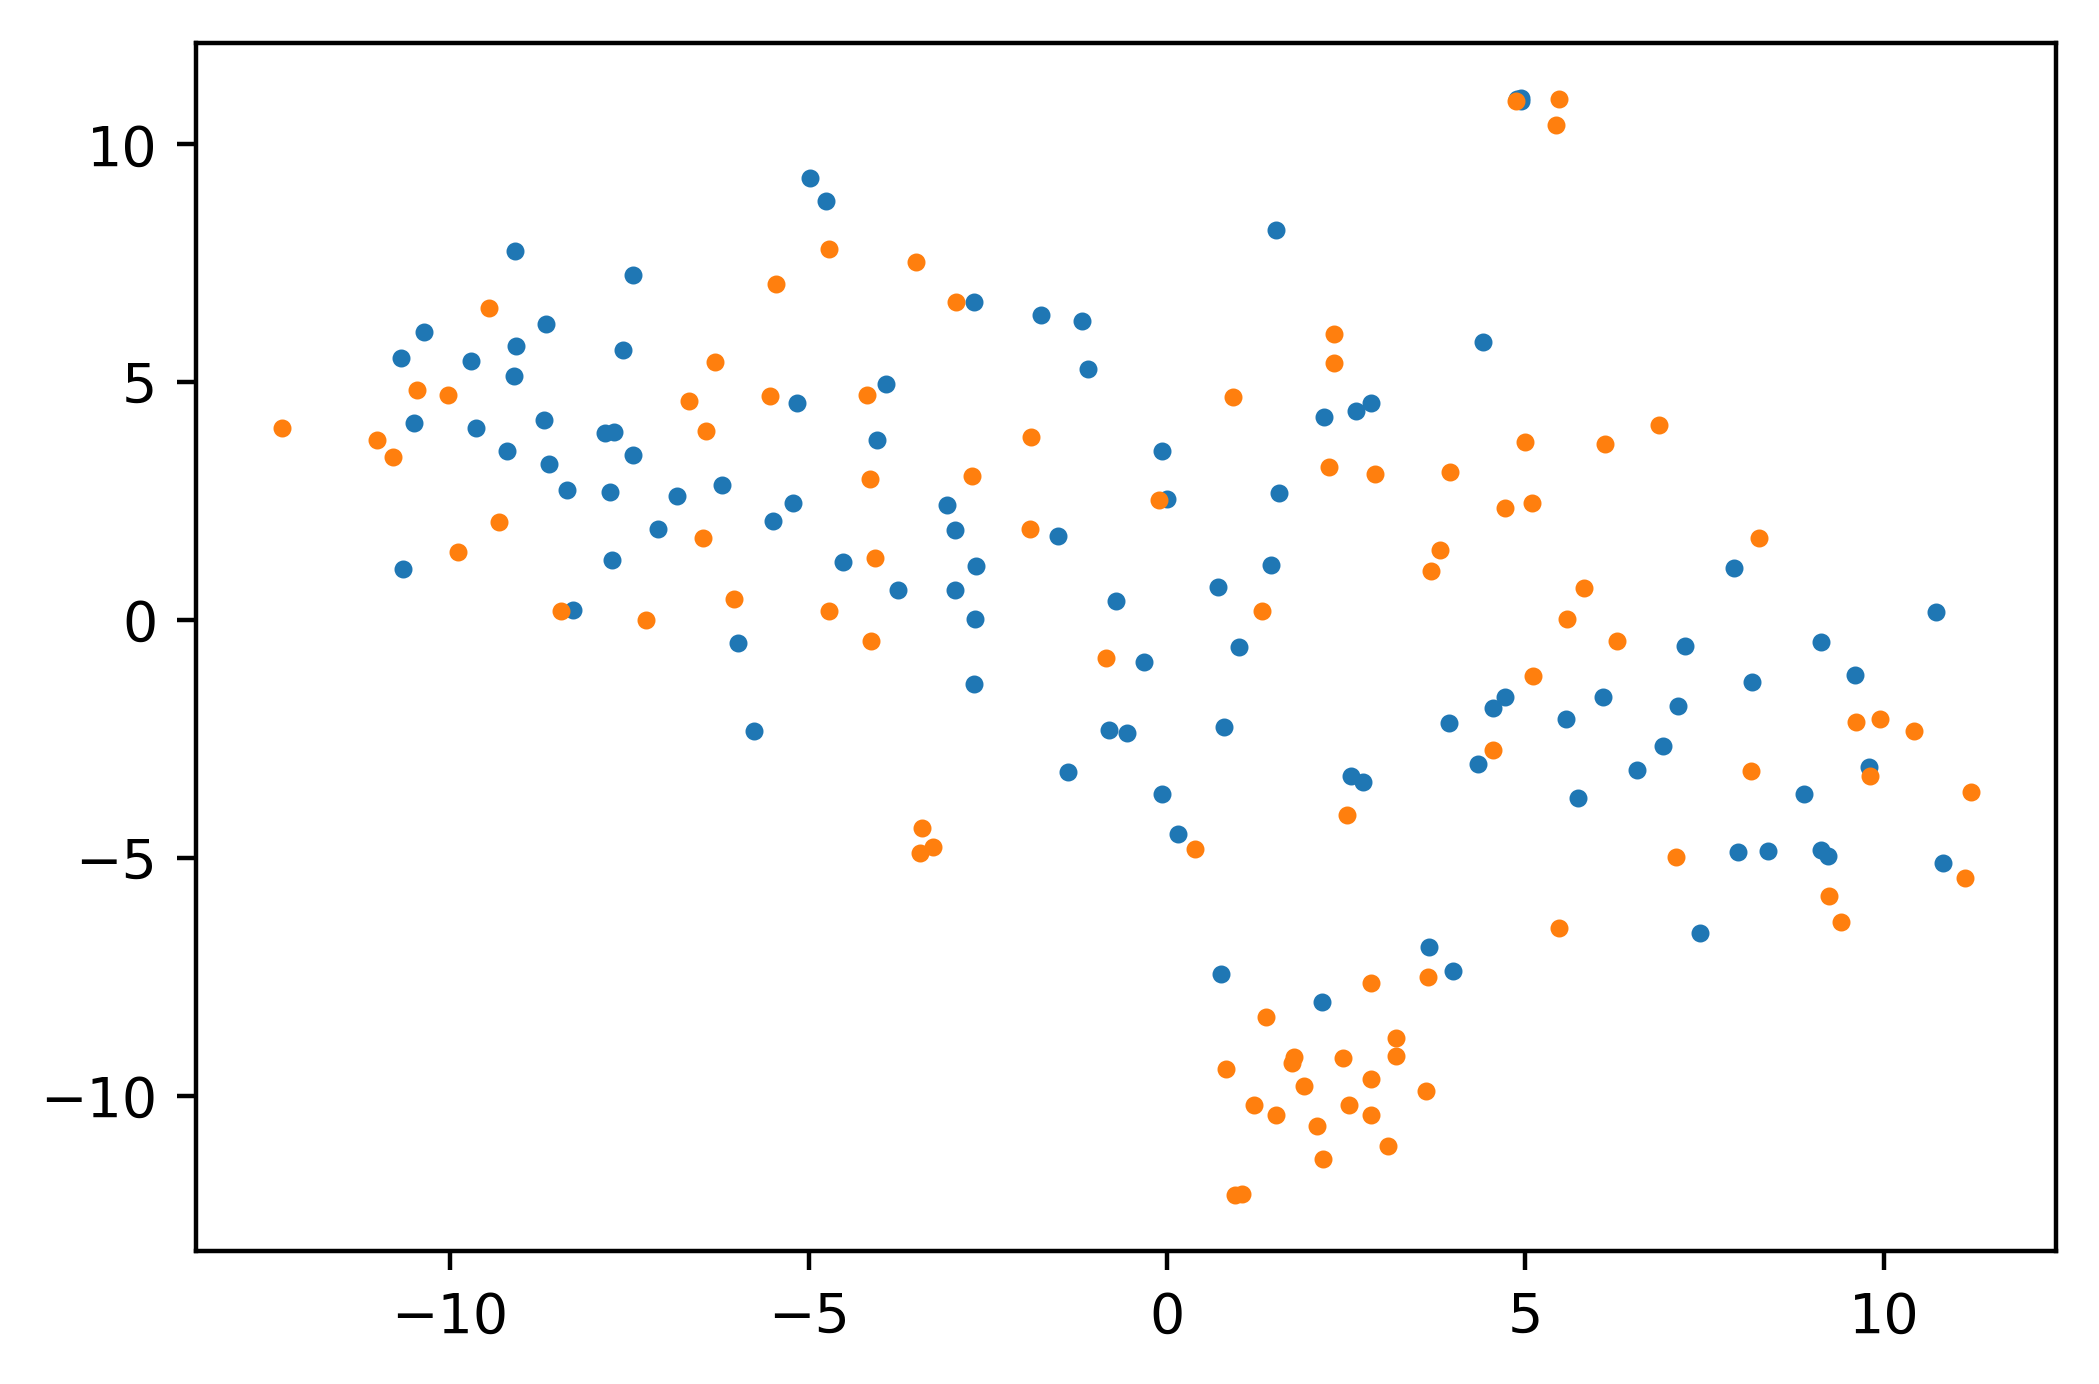

In [38]:
from sklearn.manifold import TSNE

X_embedded = TSNE(n_components=2).fit_transform(X)
plt.figure(dpi=400)
plt.scatter(X_embedded[labels==0][:,0], X_embedded[labels==0][:,1], s=5)
plt.scatter(X_embedded[labels==1][:,0], X_embedded[labels==1][:,1], s=5)

## PCA

In [39]:
from sklearn.preprocessing import StandardScaler
X_std = StandardScaler().fit_transform(X)

In [40]:
from sklearn.decomposition import PCA
pca = PCA()
X_pca = pca.fit_transform(X_std)
X_pca.shape

(189, 189)

In [41]:
var = pca.explained_variance_ratio_

In [42]:
cum_sum = pca.explained_variance_ratio_.cumsum()

Text(0.5, 1.0, 'Explained Variance')

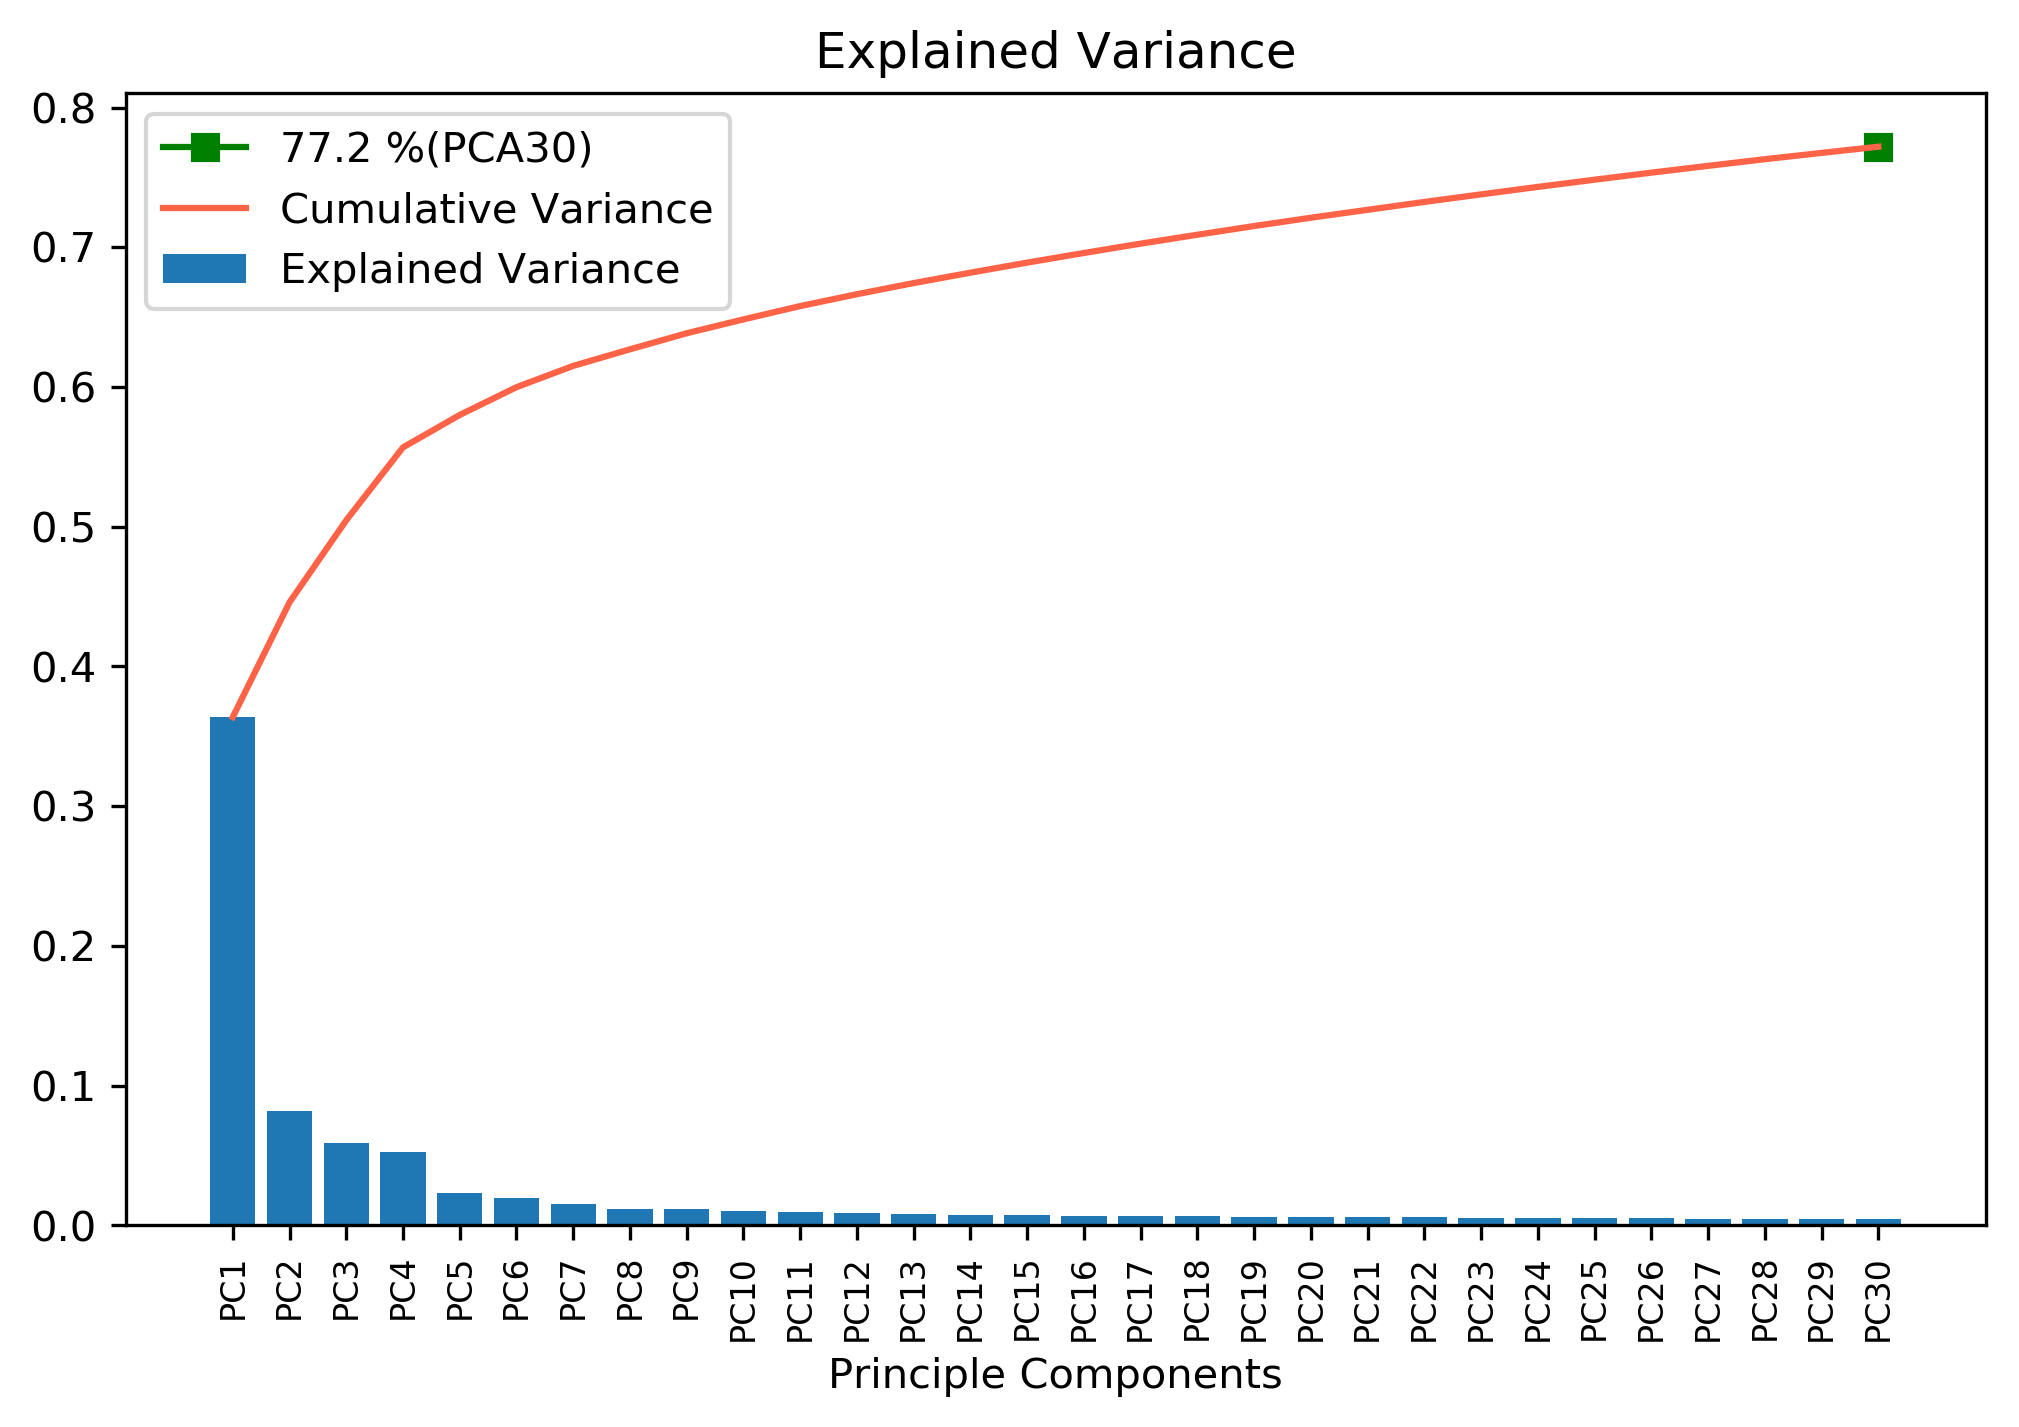

In [43]:
plt.figure(dpi=300, figsize=(8,5))
plt.plot(30, cum_sum[29], marker='s', color='green', label='%.1f %%(PCA30)' %(cum_sum[29]*100))
#plt.plot(15, 0.986, marker='s', color='darkred', label='98.6%(PCA15)')
plt.plot(range(1, 31), cum_sum[:30], color='tomato', label='Cumulative Variance')
plt.bar(range(1, 31), var[:30], label='Explained Variance')
plt.legend()
plt.xlabel('Principle Components')
plt.xticks(range(1, 31), ('PC1', 'PC2','PC3', 'PC4','PC5', 'PC6','PC7', 'PC8','PC9', 'PC10','PC11', 'PC12','PC13', 'PC14','PC15', 'PC16','PC17', 'PC18','PC19', 'PC20','PC21', 'PC22','PC23', 'PC24','PC25', 'PC26','PC27', 'PC28','PC29', 'PC30'), rotation='vertical', fontsize=8)
plt.title('Explained Variance')

In [44]:
component1 = X_pca[:,0]
component2 = X_pca[:,1]
component3 = X_pca[:,2]

Text(0.5, 0.9, 'First Three PCA Visualization')

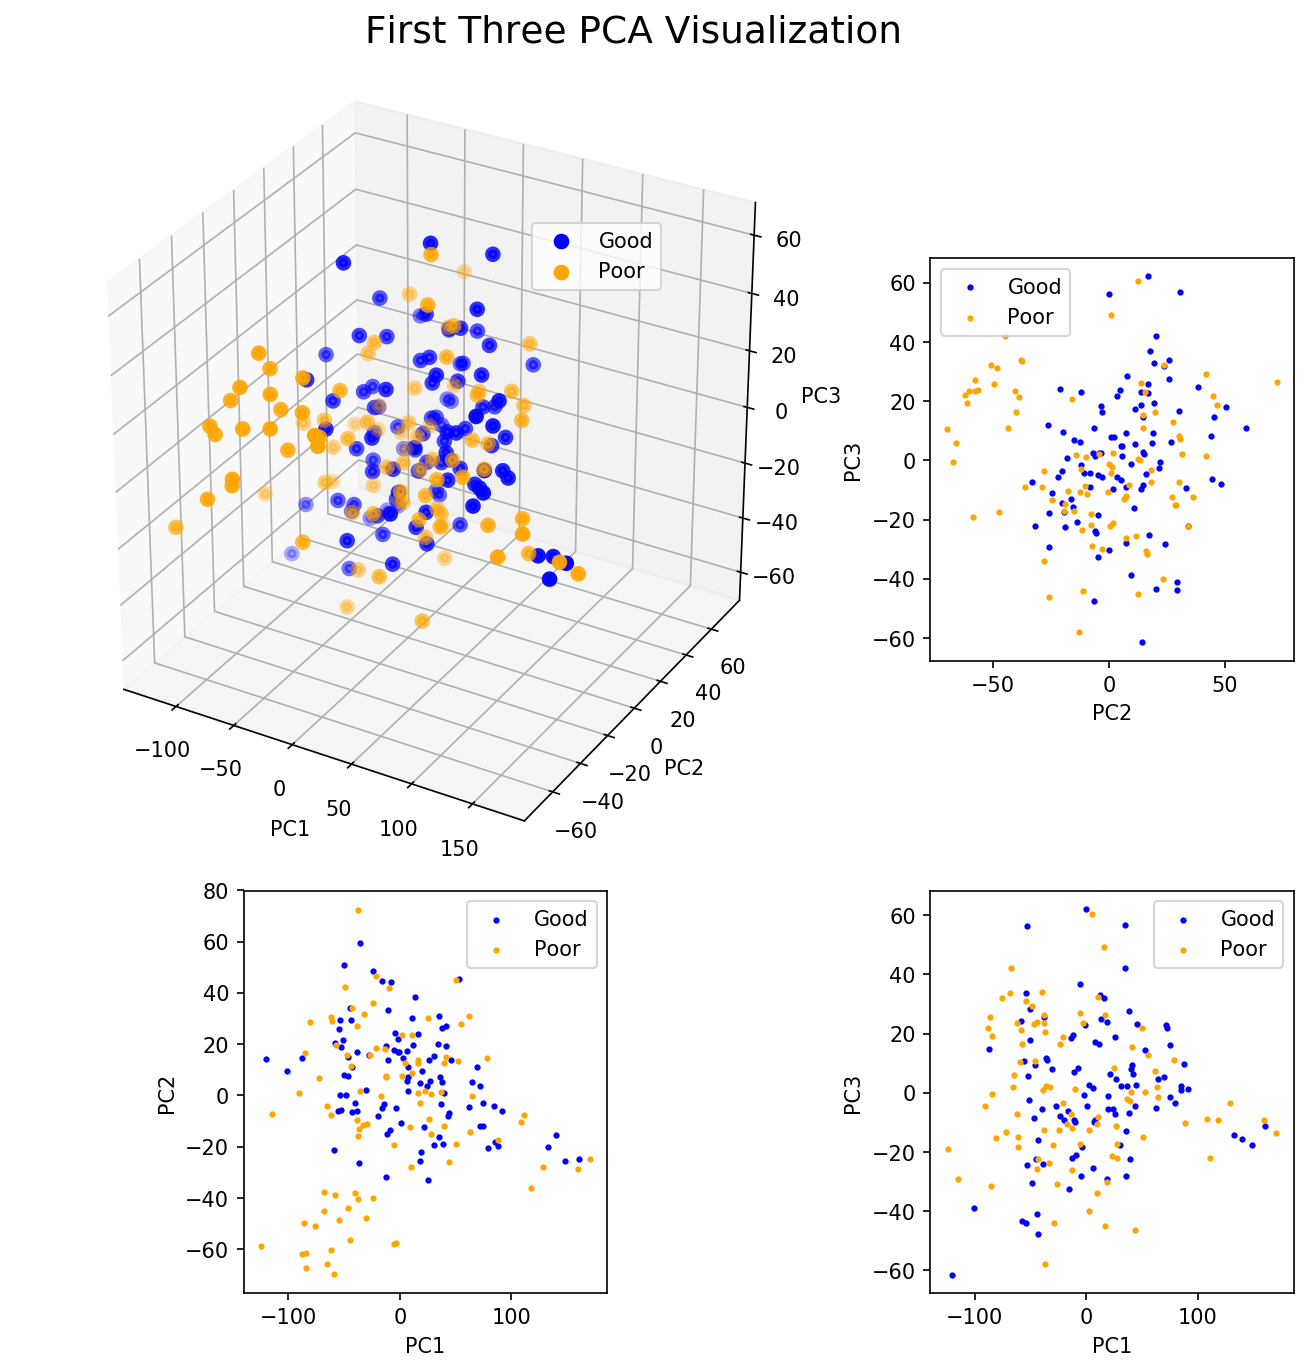

In [45]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(dpi=150, figsize=(11,11))
grid = plt.GridSpec(6, 6, hspace=0.1, wspace=0.7)
ax1 = fig.add_subplot(grid[:4, :4], projection='3d')
ax1.scatter(component1[labels==0], component2[labels==0], component3[labels==0], c='b', linewidths=3, label='Good')
ax1.scatter(component1[labels==1], component2[labels==1], component3[labels==1], c='orange', linewidths=3, label='Poor')
ax1.legend(bbox_to_anchor=(0.8, 0.8))
ax1.set_xlabel("PC1")
ax1.set_ylabel("PC2")
ax1.set_zlabel("PC3")
ax2 = fig.add_subplot(grid[4:, 1:3])
ax2.scatter(component1[labels==0], component2[labels==0], c='b', s=4, label='Good')
ax2.scatter(component1[labels==1], component2[labels==1], c='orange', s=4, label='Poor')
ax2.set_xlabel("PC1")
ax2.set_ylabel("PC2")
ax2.legend()
ax3 = fig.add_subplot(grid[1:3, 4:])
ax3.scatter(component2[labels==0], component3[labels==0], c='b', s=4, label='Good')
ax3.scatter(component2[labels==1], component3[labels==1], c='orange', s=4, label='Poor')
ax3.set_xlabel("PC2")
ax3.set_ylabel("PC3")
ax3.legend()
ax4 = fig.add_subplot(grid[4:, 4:])
ax4.scatter(component1[labels==0], component3[labels==0], c='b', s=4, label='Good')
ax4.scatter(component1[labels==1], component3[labels==1], c='orange', s=4, label='Poor')
ax4.set_xlabel("PC1")
ax4.set_ylabel("PC3")
ax4.legend()
fig.suptitle("First Three PCA Visualization", y=0.9, fontsize=18)

## Lasso Classification

In [46]:
from sklearn import linear_model

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2, random_state=0)
X_train_std = StandardScaler().fit_transform(X_train)
X_test_std = StandardScaler().fit_transform(X_test)
clf_ls = linear_model.Lasso(alpha=0.1)
clf_ls.fit(X_train, y_train)

Lasso(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [48]:
y_hat = clf_ls.predict(X_test)
y_hat[y_hat>=0.5]=1
y_hat[y_hat<0.5]=0
sum(y_hat == y_test) / y_test.shape[0]

0.6842105263157895

Text(0.5, 1.0, 'Receiver Operating Characteristic')

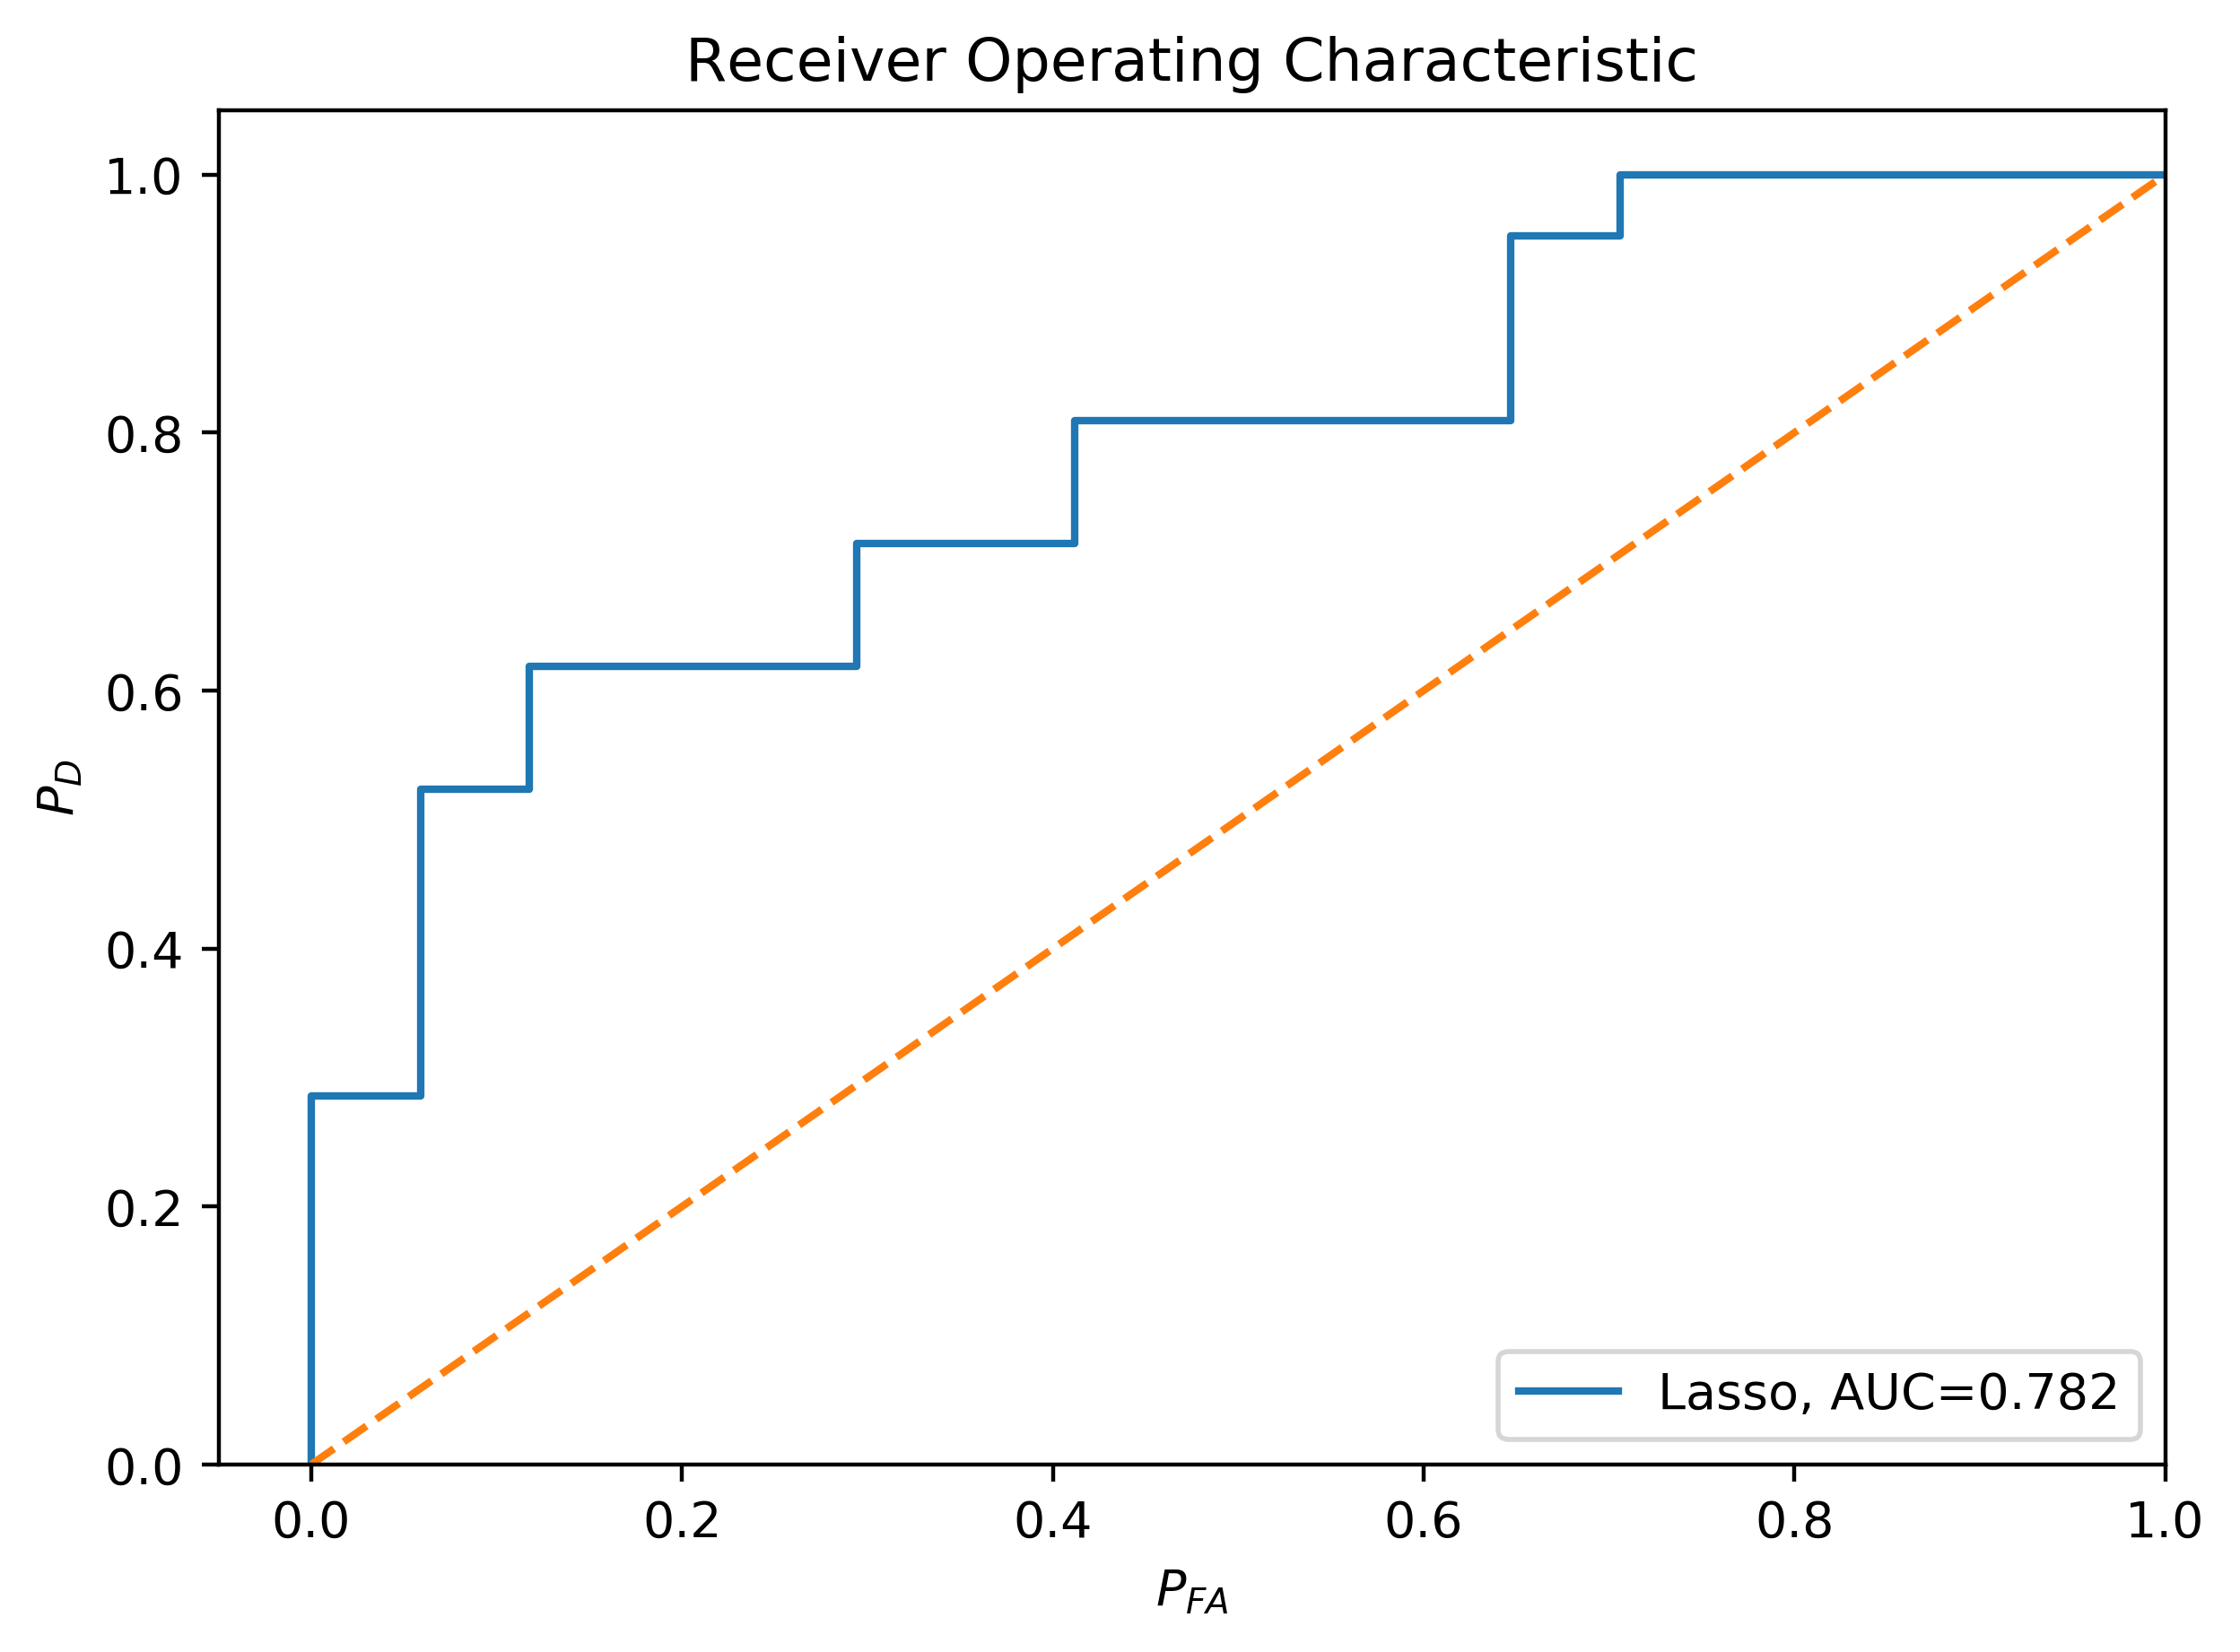

In [49]:
scores_ls = clf_ls.predict(X_test)
fpr_ls, tpr_ls, thresholds_ls = metrics.roc_curve(y_test, scores_ls)
auc_ls = metrics.auc(fpr_ls, tpr_ls)
plt.figure(dpi=400, figsize=(7,5))
plt.plot(fpr_ls, tpr_ls, label='Lasso, AUC=%.3f' %auc_ls, linestyle='-')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('$P_{FA}$')
plt.ylabel('$P_D$')
plt.legend(loc="lower right")
plt.title('Receiver Operating Characteristic')

## Conventional Classification

### PCA dimension reduction

#### logistic regression

In [50]:
from sklearn.linear_model import LogisticRegression

In [51]:
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

In [52]:
X_train_pca.shape

(151, 151)

In [53]:
X_test_pca.shape

(38, 151)

In [54]:
clf_lr = LogisticRegression(solver='liblinear').fit(X_train_pca, y_train)
scores_lr = clf_lr.predict_proba(X_test_pca)[:,1]
accuracy_lr = clf_lr.score(X_test_pca, y_test)
accuracy_lr

0.6842105263157895

In [55]:
clf_lr_1 = LogisticRegression(penalty='l1', solver='liblinear').fit(X_train_pca, y_train)
scores_lr_1 = clf_lr_1.predict_proba(X_test_pca)[:,1]
accuracy_lr_1 = clf_lr_1.score(X_test_pca, y_test)
accuracy_lr_1

0.7105263157894737

#### KNN

In [56]:
from sklearn.neighbors import KNeighborsClassifier
clf_knn = KNeighborsClassifier(n_neighbors=15)
clf_knn.fit(X_train_pca, y_train)
scores_knn = clf_knn.predict_proba(X_test_pca)[:,1]
accuracy_knn = clf_knn.score(X_test_pca, y_test)
accuracy_knn

0.5526315789473685

#### Naive Bayes

In [57]:
from sklearn.naive_bayes import GaussianNB
clf_bayes = GaussianNB().fit(X_train_pca, y_train)
scores_bayes = clf_bayes.predict_proba(X_test_pca)[:,1]
accuracy_bayes = clf_bayes.score(X_test_pca, y_test)
accuracy_bayes

0.631578947368421

#### SVM

In [58]:
from sklearn.svm import SVC
clf_svm = SVC(C=0.001,gamma='auto').fit(X_train_pca, y_train)
accuracy_svm = clf_svm.score(X_test_pca, y_test)
accuracy_svm

0.4473684210526316

#### Decision Tree

In [59]:
from sklearn.tree import DecisionTreeClassifier
clf_dt = DecisionTreeClassifier(max_depth=2, random_state=0).fit(X_train_pca, y_train)
accuracy_dt = clf_dt.score(X_test_pca, y_test)
scores_dt = clf_dt.predict_proba(X_test_pca)[:,1]
accuracy_dt

0.5789473684210527

#### Random Forest

In [60]:
from sklearn.ensemble import RandomForestClassifier
clf_rf = RandomForestClassifier(n_estimators=150, max_depth=10, random_state=0).fit(X_train_pca, y_train)
accuracy_rf = clf_rf.score(X_test_pca, y_test)
scores_rf = clf_rf.predict_proba(X_test_pca)[:,1]
accuracy_rf

0.631578947368421

Text(0.5, 1.0, 'Receiver Operating Characteristic (PCA)')

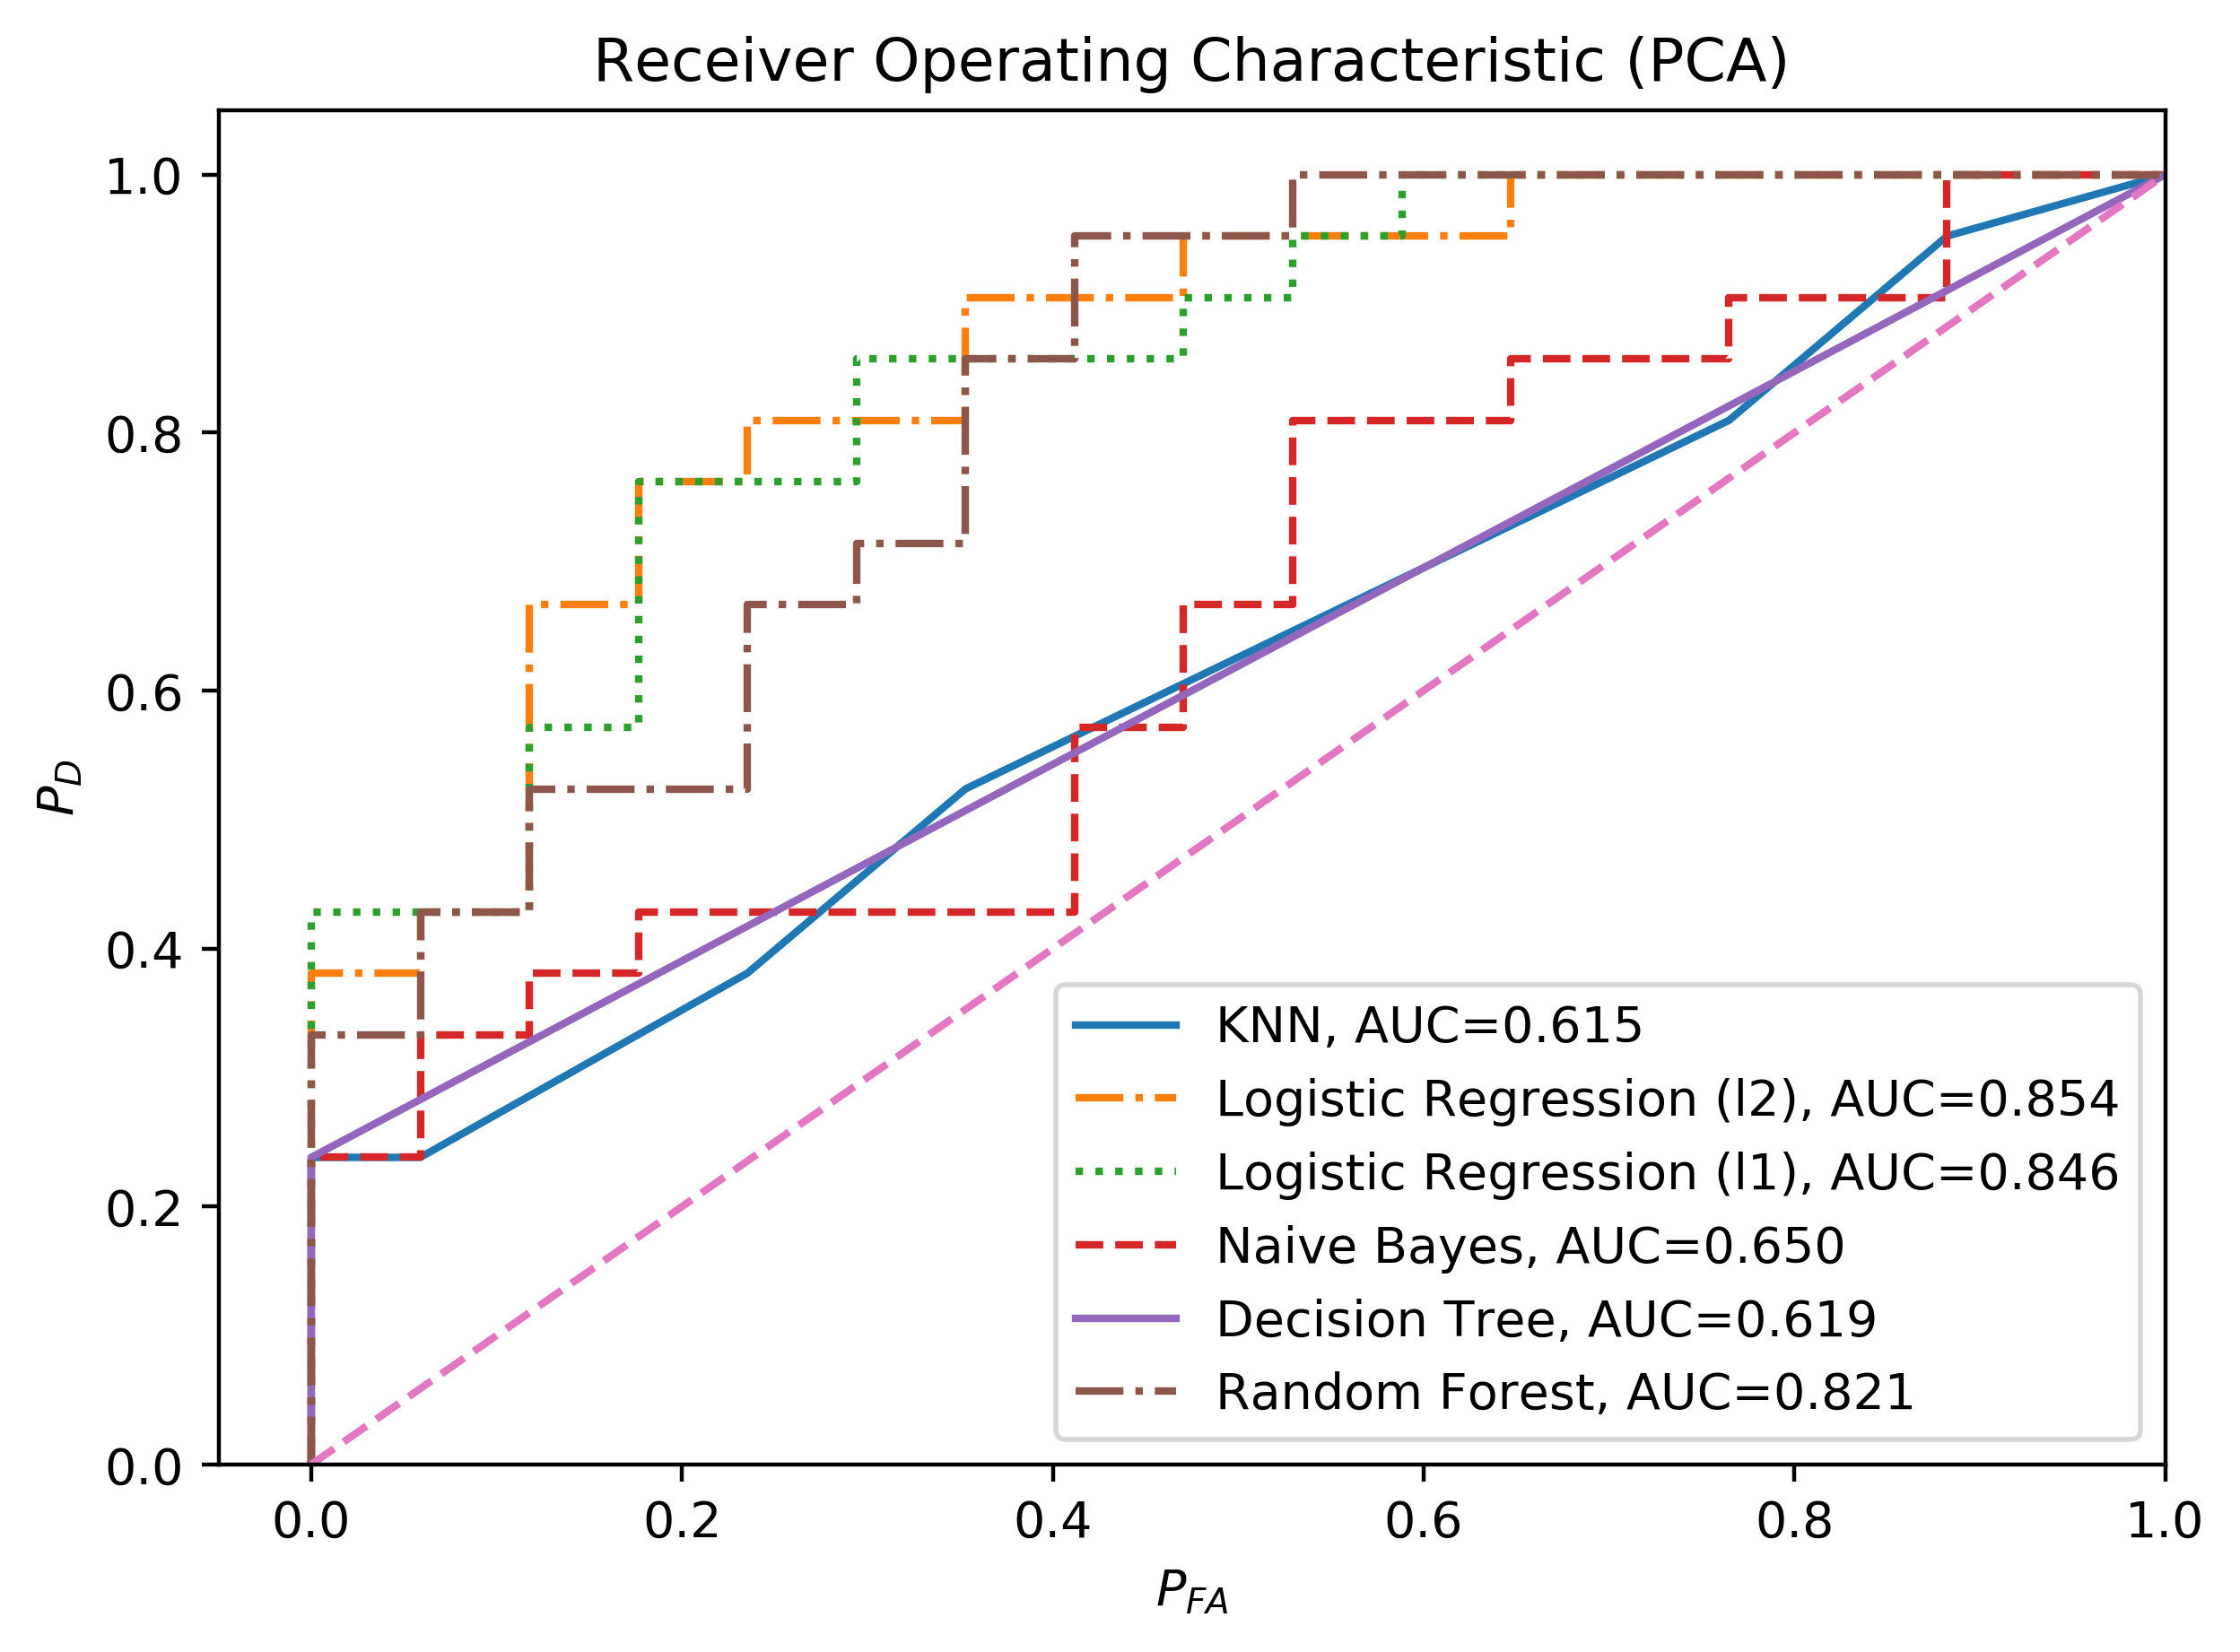

In [61]:
fpr_lr, tpr_lr, thresholds_lr = metrics.roc_curve(y_test, scores_lr)
auc_lr = metrics.auc(fpr_lr, tpr_lr)
fpr_knn, tpr_knn, thresholds_knn = metrics.roc_curve(y_test, scores_knn)
auc_knn = metrics.auc(fpr_knn, tpr_knn)
fpr_bayes, tpr_bayes, thresholds_bayes = metrics.roc_curve(y_test, scores_bayes)
auc_bayes = metrics.auc(fpr_bayes, tpr_bayes)
fpr_lr_1, tpr_lr_1, thresholds_lr_1 = metrics.roc_curve(y_test, scores_lr_1)
auc_lr_1 = metrics.auc(fpr_lr_1, tpr_lr_1)
fpr_dt, tpr_dt, thresholds_dt = metrics.roc_curve(y_test, scores_dt)
auc_dt = metrics.auc(fpr_dt, tpr_dt)
fpr_rf, tpr_rf, thresholds_rf = metrics.roc_curve(y_test, scores_rf)
auc_rf = metrics.auc(fpr_rf, tpr_rf)
plt.figure(dpi=400, figsize=(7,5))
plt.plot(fpr_knn, tpr_knn, label='KNN, AUC=%.3f' %auc_knn, linestyle='-')
plt.plot(fpr_lr, tpr_lr, label='Logistic Regression (l2), AUC=%.3f' %auc_lr, linestyle='-.')
plt.plot(fpr_lr_1 , tpr_lr_1 , label='Logistic Regression (l1), AUC=%.3f' %auc_lr_1, linestyle=':')
plt.plot(fpr_bayes, tpr_bayes, label='Naive Bayes, AUC=%.3f' %auc_bayes, linestyle='--')
plt.plot(fpr_dt, tpr_dt, label='Decision Tree, AUC=%.3f' %auc_dt, linestyle='-')
plt.plot(fpr_rf, tpr_rf, label='Random Forest, AUC=%.3f' %auc_rf, linestyle='-.')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('$P_{FA}$')
plt.ylabel('$P_D$')
plt.legend(loc="lower right")
plt.title('Receiver Operating Characteristic (PCA)')

### Lasso Feature Selection

In [62]:
clf_ls = linear_model.Lasso(alpha=0.1)
clf_ls.fit(X_train, y_train)
index = (clf_ls.coef_!=0)
X_train = X_train_std[:, index]
X_test = X_test_std[:, index]

In [63]:
clf_lr = LogisticRegression(solver='liblinear').fit(X_train, y_train)
scores_lr = clf_lr.predict_proba(X_test)[:,1]
accuracy_lr = clf_lr.score(X_test, y_test)
accuracy_lr

0.6842105263157895

In [64]:
clf_lr_1 = LogisticRegression(penalty='l1', solver='liblinear').fit(X_train, y_train)
scores_lr_1 = clf_lr_1.predict_proba(X_test)[:,1]
accuracy_lr_1 = clf_lr_1.score(X_test, y_test)
accuracy_lr_1

0.6842105263157895

In [65]:
clf_knn = KNeighborsClassifier(n_neighbors=15)
clf_knn.fit(X_train, y_train)
scores_knn = clf_knn.predict_proba(X_test)[:,1]
accuracy_knn = clf_knn.score(X_test, y_test)
accuracy_knn

0.631578947368421

In [66]:
clf_bayes = GaussianNB().fit(X_train, y_train)
scores_bayes = clf_bayes.predict_proba(X_test)[:,1]
accuracy_bayes = clf_bayes.score(X_test, y_test)
accuracy_bayes

0.6842105263157895

In [67]:
clf_dt = DecisionTreeClassifier(max_depth=2, random_state=0).fit(X_train, y_train)
accuracy_dt = clf_dt.score(X_test, y_test)
scores_dt = clf_dt.predict_proba(X_test)[:,1]
accuracy_dt

0.6052631578947368

In [68]:
clf_rf = RandomForestClassifier(n_estimators=150, max_depth=10, random_state=0).fit(X_train, y_train)
accuracy_rf = clf_rf.score(X_test, y_test)
scores_rf = clf_rf.predict_proba(X_test)[:,1]
accuracy_rf

0.7105263157894737

Text(0.5, 1.0, 'Receiver Operating Characteristic (Lasso Feature Selection)')

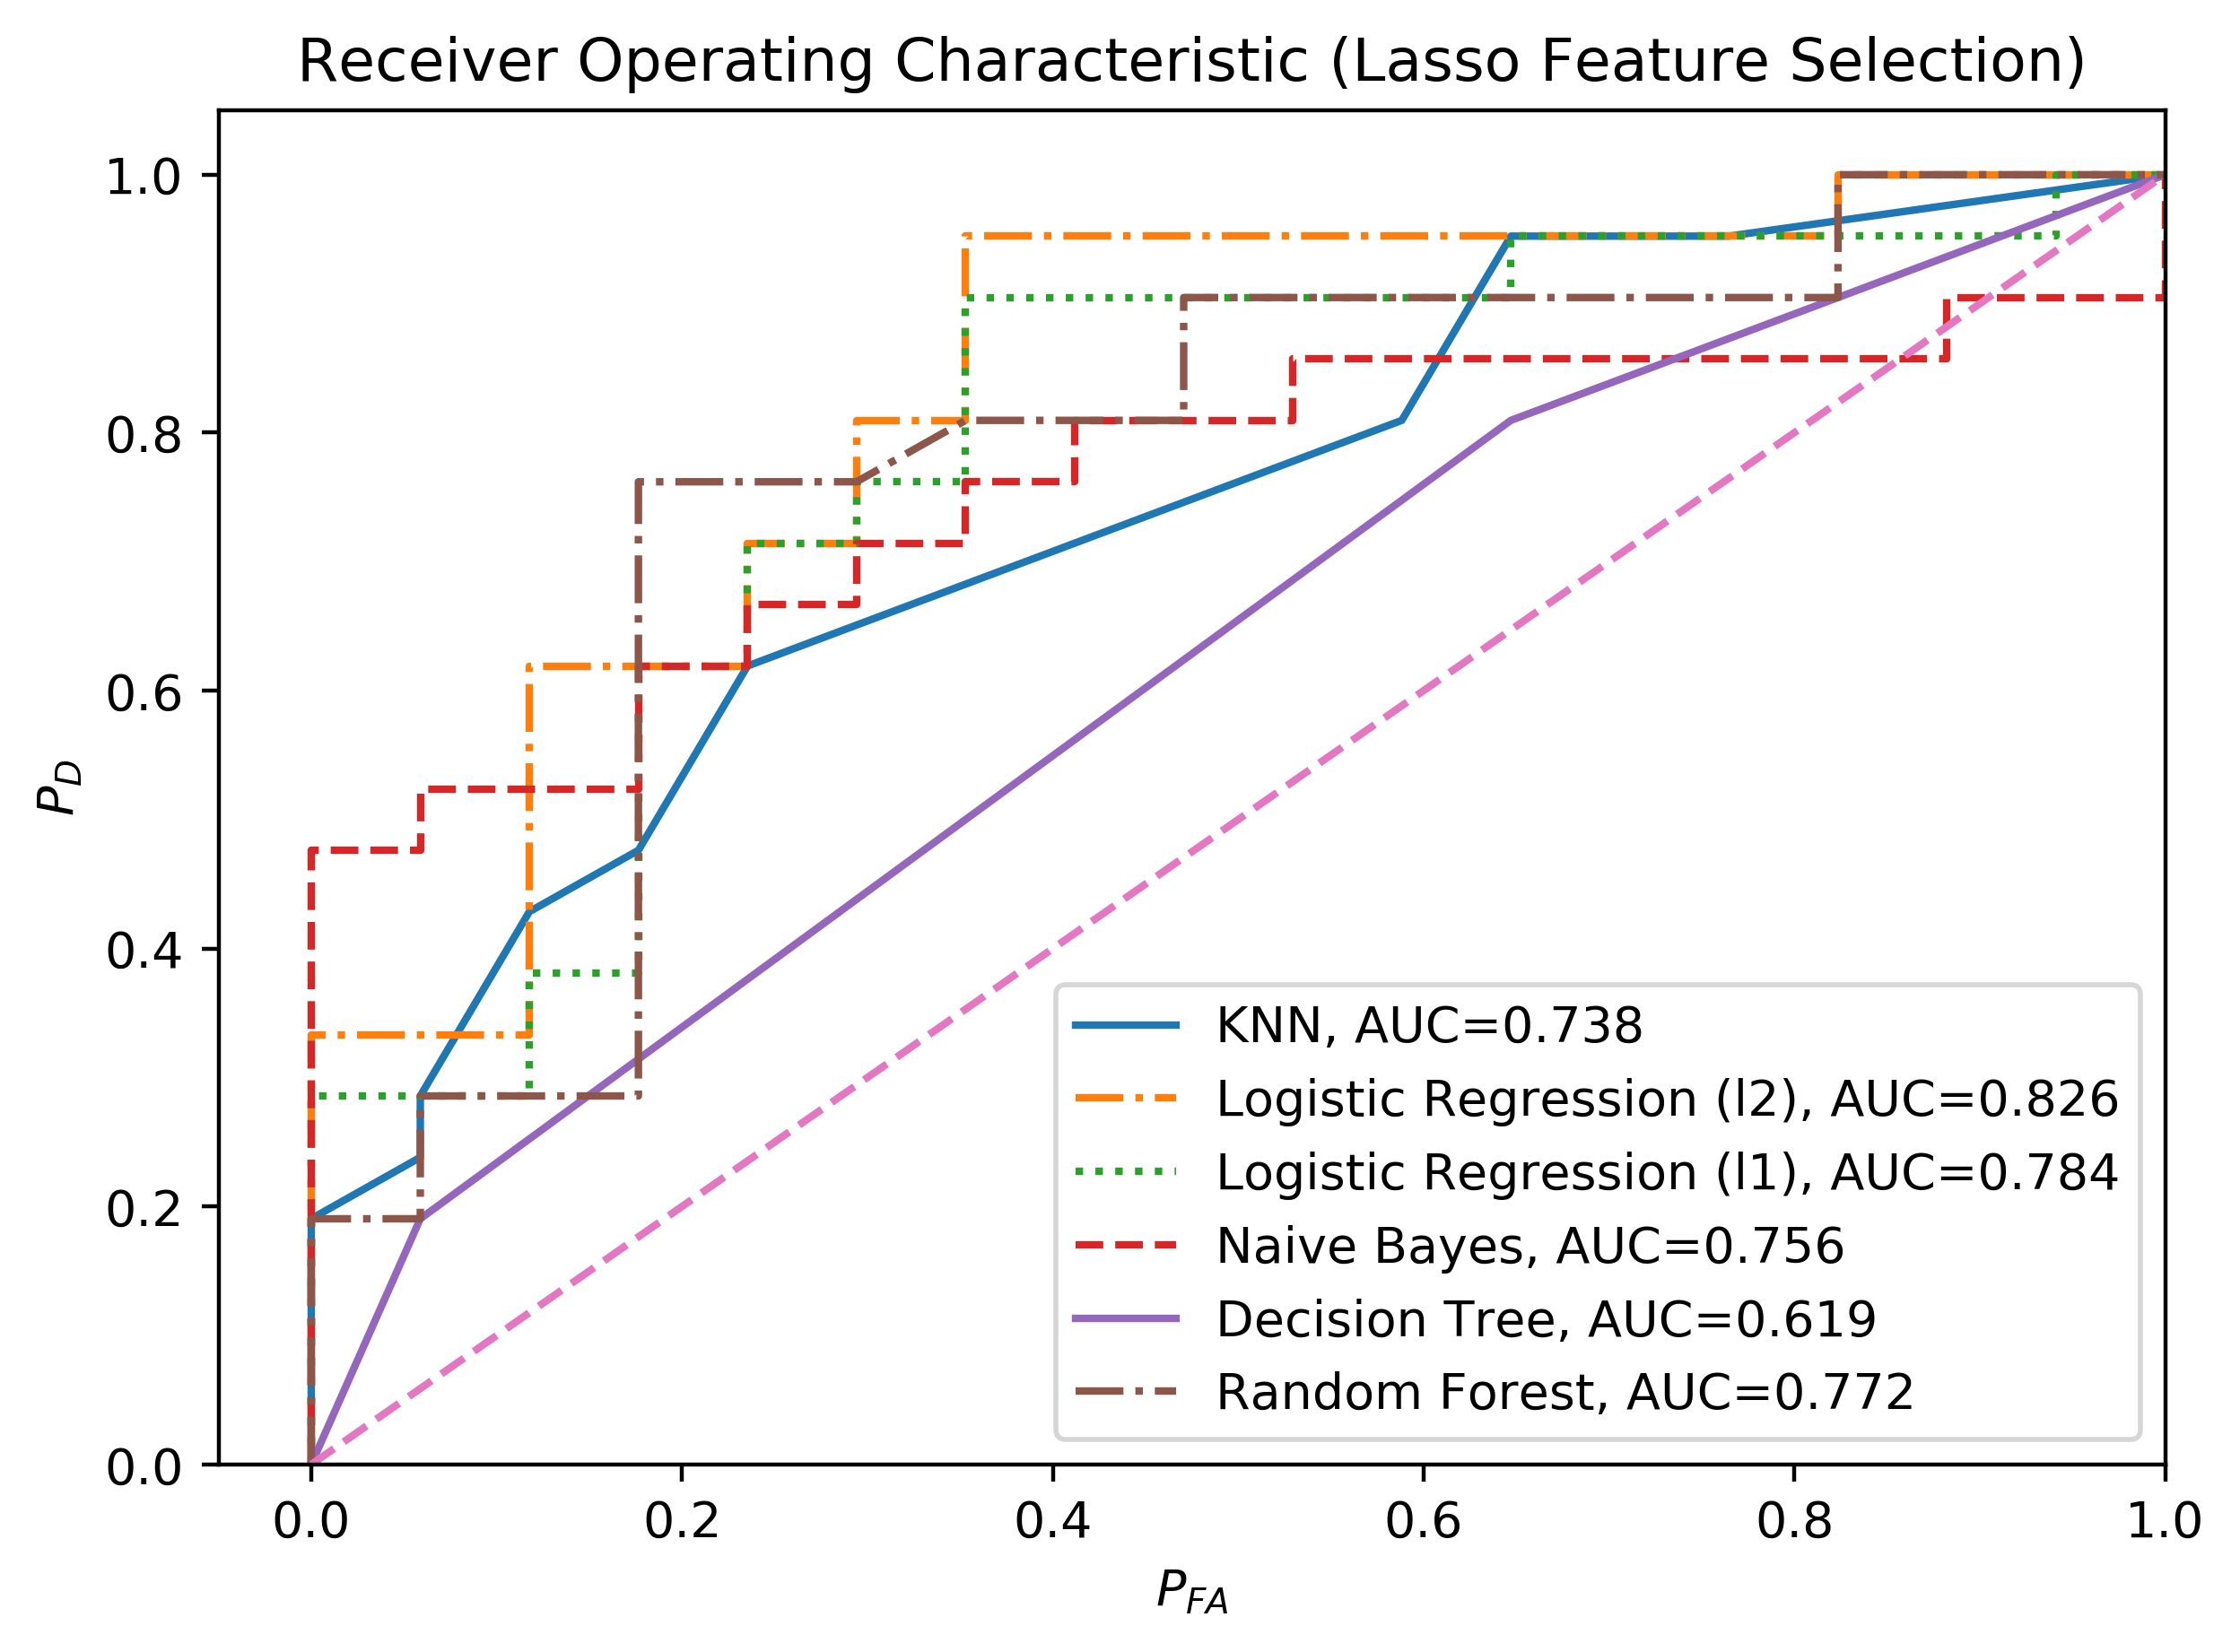

In [69]:
fpr_lr, tpr_lr, thresholds_lr = metrics.roc_curve(y_test, scores_lr)
auc_lr = metrics.auc(fpr_lr, tpr_lr)
fpr_knn, tpr_knn, thresholds_knn = metrics.roc_curve(y_test, scores_knn)
auc_knn = metrics.auc(fpr_knn, tpr_knn)
fpr_bayes, tpr_bayes, thresholds_bayes = metrics.roc_curve(y_test, scores_bayes)
auc_bayes = metrics.auc(fpr_bayes, tpr_bayes)
fpr_lr_1, tpr_lr_1, thresholds_lr_1 = metrics.roc_curve(y_test, scores_lr_1)
auc_lr_1 = metrics.auc(fpr_lr_1, tpr_lr_1)
fpr_dt, tpr_dt, thresholds_dt = metrics.roc_curve(y_test, scores_dt)
auc_dt = metrics.auc(fpr_dt, tpr_dt)
fpr_rf, tpr_rf, thresholds_rf = metrics.roc_curve(y_test, scores_rf)
auc_rf = metrics.auc(fpr_rf, tpr_rf)
plt.figure(dpi=400, figsize=(7,5))
plt.plot(fpr_knn, tpr_knn, label='KNN, AUC=%.3f' %auc_knn, linestyle='-')
plt.plot(fpr_lr, tpr_lr, label='Logistic Regression (l2), AUC=%.3f' %auc_lr, linestyle='-.')
plt.plot(fpr_lr_1 , tpr_lr_1 , label='Logistic Regression (l1), AUC=%.3f' %auc_lr_1, linestyle=':')
plt.plot(fpr_bayes, tpr_bayes, label='Naive Bayes, AUC=%.3f' %auc_bayes, linestyle='--')
plt.plot(fpr_dt, tpr_dt, label='Decision Tree, AUC=%.3f' %auc_dt, linestyle='-')
plt.plot(fpr_rf, tpr_rf, label='Random Forest, AUC=%.3f' %auc_rf, linestyle='-.')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('$P_{FA}$')
plt.ylabel('$P_D$')
plt.legend(loc="lower right")
plt.title('Receiver Operating Characteristic (Lasso Feature Selection)')